<a href="https://colab.research.google.com/github/emh0841-code/Final-Team9/blob/main/%EC%B5%9C%EC%A2%85)%EC%8B%9C%EB%8C%80%EC%97%90_%EB%94%B0%EB%9D%BC_%ED%9D%A5%ED%96%89%ED%95%98%EB%8A%94_%EC%9E%A5%EB%A5%B4%EA%B0%80_%EB%8B%A4%EB%A5%BC%EA%B2%83%EC%9D%B4%EB%8B%A4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

# 표에서 ('-') 마이너스 표시
plt.rcParams['axes.unicode_minus'] = False

# 필요한 라이브러리 임포트
import pandas as pd # 데이터 분석 라이브러리
import numpy as np
import matplotlib.pyplot as plt # 시각화 도구 라이브러리1
import seaborn as sns # 시각화 도구 라이브러리2

In [2]:
df = pd.read_csv("/content/movies_genres_ohe.csv", on_bad_lines='skip')

[1990~2025] 장르별 전체 편수:
 Drama              3079
Comedy             2376
Thriller           1760
Action             1744
Adventure          1187
Romance            1174
Crime              1039
Family              737
Horror              736
Science Fiction     696
Fantasy             696
Mystery             575
Animation           418
History             361
War                 212
Music               197
Documentary          75
Western              72
TV Movie              7
dtype: int64 

5년 단위 × 장르별 평균 y_result (1990~2025):
             Action  Adventure  Animation    Comedy     Crime  Documentary  \
period                                                                       
1990–1994  1.208092   1.297030   1.047619  1.093117  1.070423     2.000000   
1995–1999  1.114286   1.422764   1.500000  1.117284  1.142857     0.600000   
2000–2004  1.071161   1.396341   1.553191  1.174242  1.000000     1.555556   
2005–2009  1.152597   1.256410   1.469880  1.118126  0.989848     1.153846   


/tmp/ipython-input-2621840106.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_genre[c] = df.loc[df[c] == 1].groupby("period")["y_result"].mean()


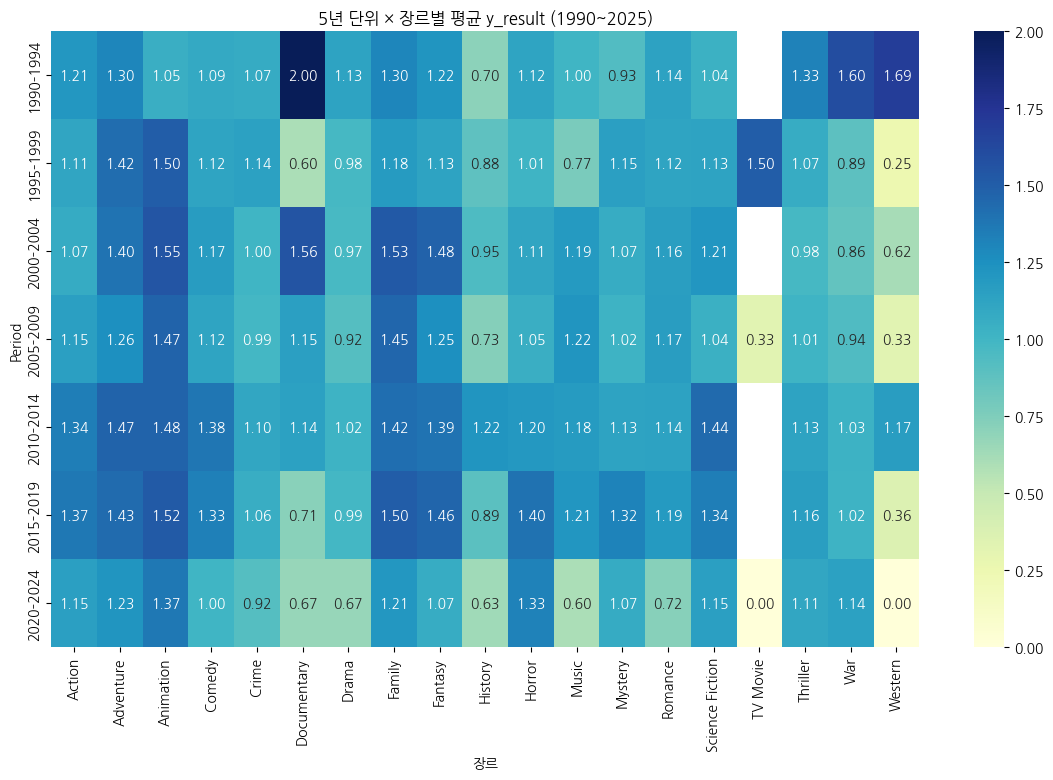

1990~2025 상위 5개 장르: ['Animation', 'Family', 'Adventure', 'Fantasy', 'Action'] 



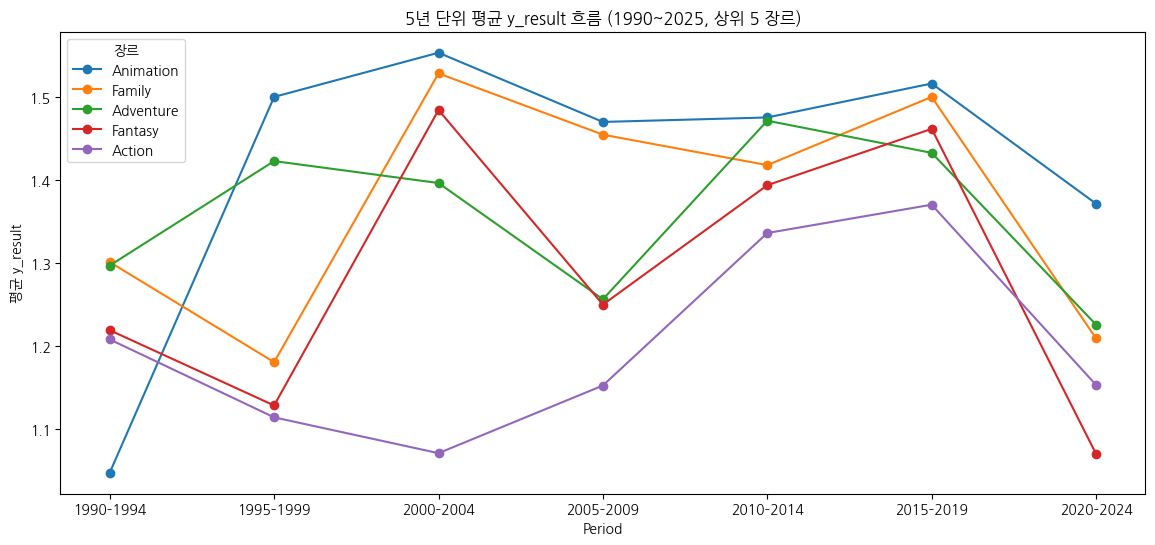

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, f_oneway, kruskal

df.columns = df.columns.str.strip()

# 날짜 → year
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["year"] = df["release_date"].dt.year

# ===== 1) 1990~2025 구간 필터 =====
df = df[(df["year"] >= 1990) & (df["year"] <= 2025)].copy()

# ===== 2) 5년 단위 구간 만들기 =====
bins   = list(range(1990, 2030, 5))   # [1990,1995,...,2025]
labels = [f"{y}–{y+4}" for y in bins[:-1]]
df["period"] = pd.cut(df["year"], bins=bins, labels=labels, right=True, include_lowest=True)

# ===== 3) 장르(0/1) 컬럼 추출 =====
cols = df.loc[:, "Action":"Western"].columns.tolist()

# ===== 4) 장르별 전체 편수 확인 =====
col_counts = df[cols].sum().sort_values(ascending=False)
print("[1990~2025] 장르별 전체 편수:\n", col_counts, "\n")

# ===== 5) 시대 × 장르별 y_result 평균 =====
period_genre = {}
for c in cols:
    period_genre[c] = df.loc[df[c] == 1].groupby("period")["y_result"].mean()

period_genre = pd.DataFrame(period_genre).sort_index()
print("5년 단위 × 장르별 평균 y_result (1990~2025):")
print(period_genre, "\n")

# ===== 6) 히트맵 시각화 =====
plt.figure(figsize=(14,8))
sns.heatmap(period_genre, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("5년 단위 × 장르별 평균 y_result (1990~2025)")
plt.xlabel("장르")
plt.ylabel("Period")
plt.show()

# ===== 7) 전체 기간 평균 기준 상위 5개 장르 =====
topN = 5
top_cols = period_genre.mean().sort_values(ascending=False).head(topN).index.tolist()
print(f"1990~2025 상위 {topN}개 장르:", top_cols, "\n")

# 라인그래프 (Top5 트렌드)
period_genre[top_cols].plot(marker="o", figsize=(14,6))
plt.title(f"5년 단위 평균 y_result 흐름 (1990~2025, 상위 {topN} 장르)")
plt.xlabel("Period")
plt.ylabel("평균 y_result")
plt.legend(title="장르")
plt.show()


In [4]:
from scipy.stats import shapiro, levene, f_oneway, kruskal

# 1) 정규성 검정 (Shapiro-Wilk)
print("[정규성 검정: Shapiro-Wilk] (1990~2025, 전체 장르)")
normality_results = {}
for c in cols:  # cols = ['Action', ..., 'Western']
    vals = df.loc[df[c] == 1, "y_result"].dropna()
    if len(vals) >= 8:  # 샘플이 너무 적으면 제외
        stat, p = shapiro(vals)
        normality_results[c] = (stat, p, len(vals))
        print(f"{c:15s} → W={stat:.4f}, p={p:.4e}, n={len(vals)}")
    else:
        print(f"{c:15s} → 샘플 부족 (n={len(vals)})")

# 2) 등분산성 검정 (Levene test, 모든 장르 비교)
groups = [df.loc[df[c] == 1, "y_result"].dropna() for c in cols if len(df.loc[df[c] == 1, "y_result"].dropna()) > 1]
stat, p = levene(*groups)
print(f"\n[등분산성 검정: Levene]\nW={stat:.4f}, p={p:.4e}")

# 3) ANOVA & Kruskal-Wallis
if all(pv > 0.05 for _, pv, _ in normality_results.values()):
    # 전체 장르가 정규성을 만족한다면 ANOVA
    f_stat, p_val = f_oneway(*groups)
    print(f"\n[ANOVA 결과]\nF={f_stat:.4f}, p={p_val:.4e}")
else:
    # 정규성 깨지면 Kruskal-Wallis
    h_stat, p_val = kruskal(*groups)
    print(f"\n[Kruskal-Wallis 결과]\nH={h_stat:.4f}, p={p_val:.4e}")


[정규성 검정: Shapiro-Wilk] (1990~2025, 전체 장르)
Action          → W=0.8450, p=2.8646e-38, n=1744
Adventure       → W=0.8461, p=1.9944e-32, n=1187
Animation       → W=0.8325, p=1.3704e-20, n=418
Comedy          → W=0.8490, p=6.7137e-43, n=2376
Crime           → W=0.8313, p=9.8873e-32, n=1039
Documentary     → W=0.8033, p=1.2924e-08, n=75
Drama           → W=0.8158, p=1.1662e-50, n=3079
Family          → W=0.8550, p=1.8426e-25, n=737
Fantasy         → W=0.8463, p=2.0400e-25, n=696
History         → W=0.7880, p=2.4090e-21, n=361
Horror          → W=0.8476, p=5.2526e-26, n=736
Music           → W=0.8116, p=1.0895e-14, n=197
Mystery         → W=0.8261, p=1.7092e-24, n=575
Romance         → W=0.8438, p=1.8238e-32, n=1174
Science Fiction → W=0.8369, p=4.4562e-26, n=696
TV Movie        → 샘플 부족 (n=7)
Thriller        → W=0.8354, p=2.8764e-39, n=1760
War             → W=0.8084, p=2.0011e-15, n=212
Western         → W=0.7009, p=8.0630e-11, n=72

[등분산성 검정: Levene]
W=5.3405, p=1.2376e-12

[Kruskal-Wallis 

1990~2025년 전체 장르 간 y_result 분포에는 매우 유의한 차이

최신기간기준 top5

2020–2024 Top5 장르: ['Animation', 'Horror', 'Adventure', 'Family', 'Action']

2020–2024 Top5 장르의 5년 단위 평균 y_result 흐름:
           Animation    Horror  Adventure    Family    Action
period                                                       
1990–1994   1.047619  1.121212   1.297030  1.301205  1.208092
1995–1999   1.500000  1.013333   1.422764  1.180723  1.114286
2000–2004   1.553191  1.112150   1.396341  1.528302  1.071161
2005–2009   1.469880  1.051948   1.256410  1.454545  1.152597
2010–2014   1.475248  1.198529   1.471366  1.417910  1.336158
2015–2019   1.516129  1.400000   1.432653  1.500000  1.370262
2020–2024   1.371429  1.327586   1.225806  1.209302  1.153226


/tmp/ipython-input-2399130131.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_trend[c] = df.loc[df[c]==1].groupby("period")["y_result"].mean()


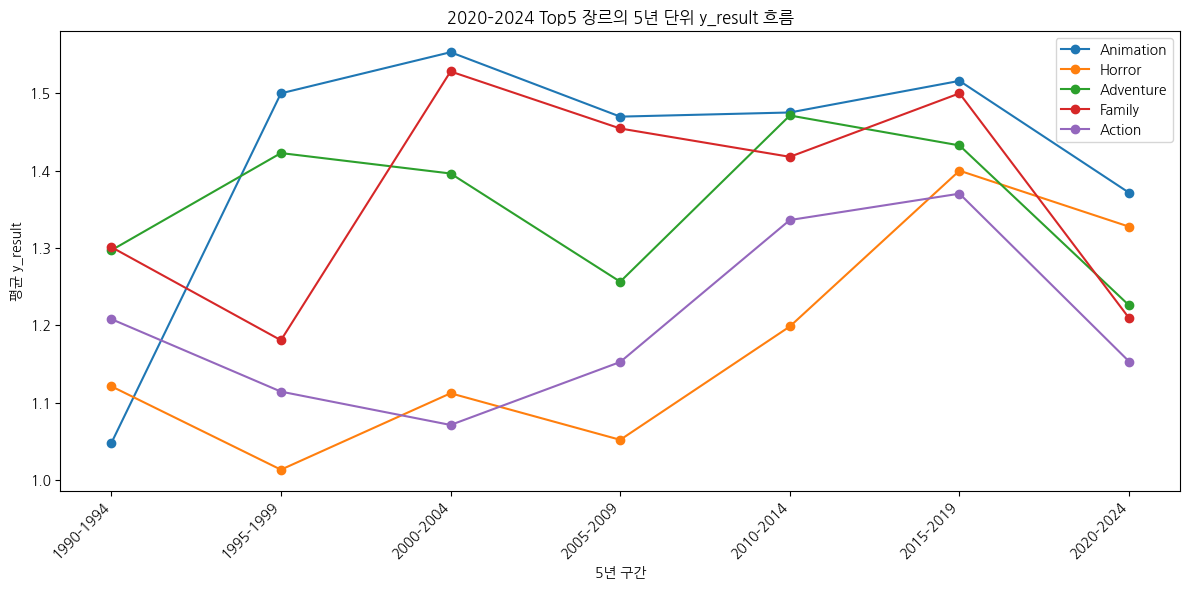

In [5]:

# 0) year & 5년 구간(period) 만들기
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["year"] = df["release_date"].dt.year
df = df[(df["year"] >= 1990) & (df["year"] <= 2025)].copy()

bins   = list(range(1990, 2030, 5))                 # [1990,1995,...,2025]
labels = [f"{y}–{y+4}" for y in bins[:-1]]          # '1990–1994' 형식
df["period"] = pd.cut(df["year"], bins=bins, labels=labels, right=True, include_lowest=True)

# 1) 장르 컬럼
cols = df.loc[:, "Action":"Western"].columns.tolist()

# 2) '2020–2024'에서 장르별 평균 y_result → Top5
latest_period = "2020–2024"
df_latest = df[df["period"] == latest_period].copy()

genre_mean_latest = {
    c: df_latest.loc[df_latest[c]==1, "y_result"].mean() for c in cols
}
genre_mean_latest = pd.Series(genre_mean_latest).dropna().sort_values(ascending=False)

topN = 5
top_cols_latest = genre_mean_latest.head(topN).index.tolist()
print(f"{latest_period} Top{topN} 장르:", top_cols_latest)

# 3) 전체(1990~2025)에서 이 Top5 장르의 5년 단위 평균 y_result 흐름
period_trend = {}
for c in top_cols_latest:
    period_trend[c] = df.loc[df[c]==1].groupby("period")["y_result"].mean()

period_trend = pd.DataFrame(period_trend).reindex(labels)  # 구간 순서 보장
print(f"\n{latest_period} Top{topN} 장르의 5년 단위 평균 y_result 흐름:")
print(period_trend)

# 4) 시각화
ax = period_trend.plot(marker="o", figsize=(12,6))
ax.set_title(f"{latest_period} Top{topN} 장르의 5년 단위 y_result 흐름")
ax.set_xlabel("5년 구간")
ax.set_ylabel("평균 y_result")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


전체기간 기준으로 top5

1990~2025 전체 평균 기준 Top5 장르: ['Animation', 'Family', 'Adventure', 'Fantasy', 'Action']

Top5 장르의 5년 단위 평균 y_result 트렌드:
           Animation    Family  Adventure   Fantasy    Action
period                                                       
1990–1994   1.047619  1.301205   1.297030  1.219178  1.208092
1995–1999   1.500000  1.180723   1.422764  1.128571  1.114286
2000–2004   1.553191  1.528302   1.396341  1.484211  1.071161
2005–2009   1.469880  1.454545   1.256410  1.250000  1.152597
2010–2014   1.475248  1.417910   1.471366  1.393701  1.336158
2015–2019   1.516129  1.500000   1.432653  1.461538  1.370262
2020–2024   1.371429  1.209302   1.225806  1.070175  1.153226


/tmp/ipython-input-2822011959.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_trend[c] = df.loc[df[c]==1].groupby("period")["y_result"].mean()


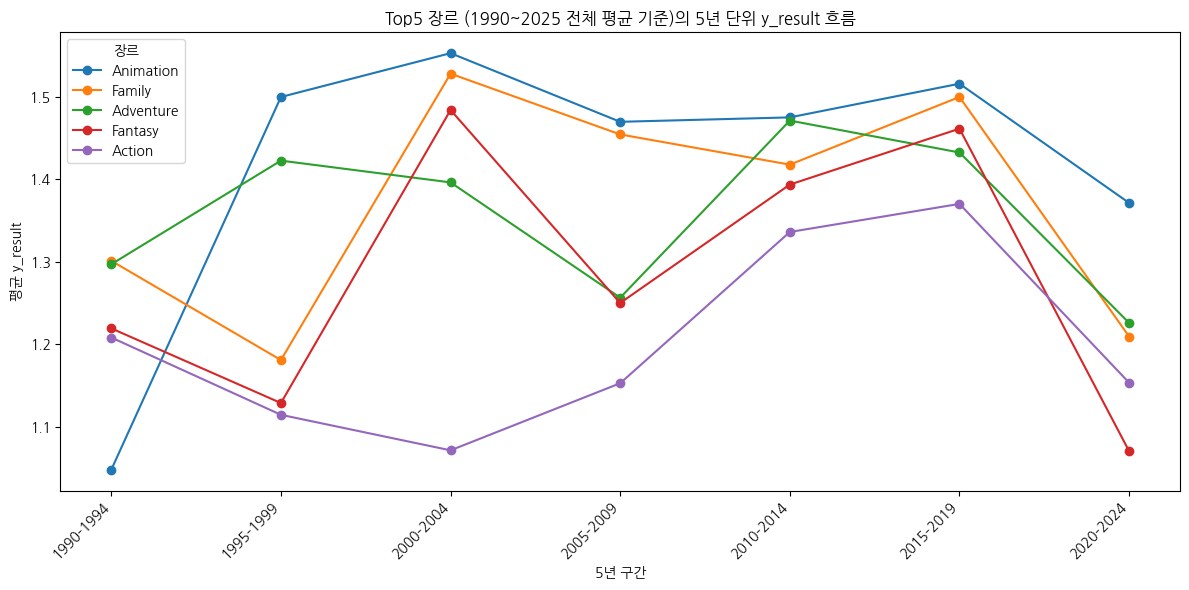

In [6]:


# ===== 0) year & 5년 구간 만들기
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["year"] = df["release_date"].dt.year
df = df[(df["year"] >= 1990) & (df["year"] <= 2025)].copy()

bins   = list(range(1990, 2030, 5))                 # [1990,1995,...,2025]
labels = [f"{y}–{y+4}" for y in bins[:-1]]
df["period"] = pd.cut(df["year"], bins=bins, labels=labels,
                      right=True, include_lowest=True)

# ===== 1) 장르 컬럼
cols = df.loc[:, "Action":"Western"].columns.tolist()

# ===== 2) 전체 구간에서 장르별 평균 y_result
genre_mean_all = {
    c: df.loc[df[c]==1, "y_result"].mean() for c in cols
}
genre_mean_all = pd.Series(genre_mean_all).dropna().sort_values(ascending=False)

topN = 5   # 상위 몇 개 장르를 볼지
top_cols_all = genre_mean_all.head(topN).index.tolist()
print(f"1990~2025 전체 평균 기준 Top{topN} 장르:", top_cols_all)

# ===== 3) 이 TopN 장르들의 5년 단위 평균 y_result 트렌드
period_trend = {}
for c in top_cols_all:
    period_trend[c] = df.loc[df[c]==1].groupby("period")["y_result"].mean()

period_trend = pd.DataFrame(period_trend).reindex(labels)  # 구간 순서 보장

print(f"\nTop{topN} 장르의 5년 단위 평균 y_result 트렌드:")
print(period_trend)

# ===== 4) 시각화
plt.figure(figsize=(12,6))
for c in top_cols_all:
    plt.plot(period_trend.index, period_trend[c], marker="o", label=c)

plt.title(f"Top{topN} 장르 (1990~2025 전체 평균 기준)의 5년 단위 y_result 흐름")
plt.xlabel("5년 구간")
plt.ylabel("평균 y_result")
plt.xticks(rotation=45, ha="right")
plt.legend(title="장르")
plt.tight_layout()
plt.show()


최신기간 기준

 2020년대 기준 Top5 장르: ['Horror', 'Animation', 'War', 'Science Fiction', 'Family']


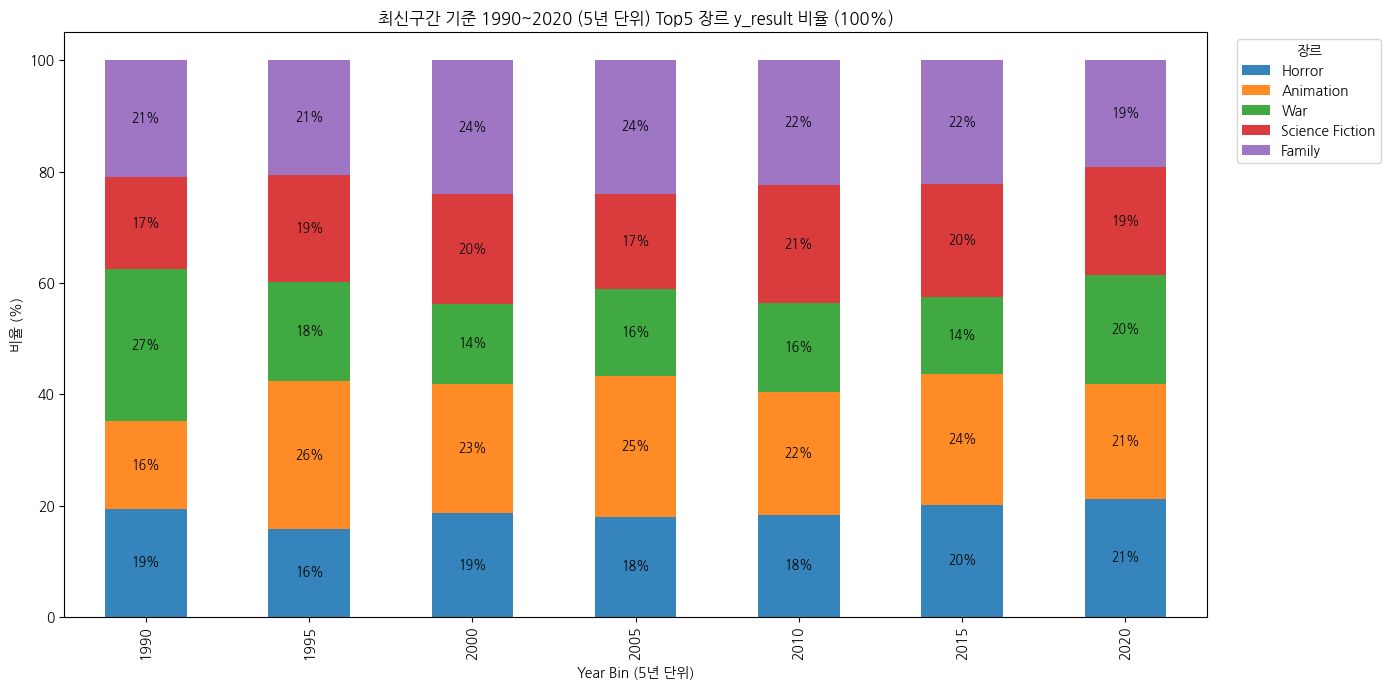

In [7]:

# ===== 1) release_year & year_bin 생성 =====
df["release_year"] = pd.to_datetime(df["release_date"], errors="coerce").dt.year
df = df[df["release_year"].notna()].copy()
df["release_year"] = df["release_year"].astype(int)

# 5년 단위 bin
df["year_bin"] = (df["release_year"] // 5) * 5

# 1990~2025년만 사용
df = df[df["year_bin"] >= 1990].copy()
df.loc[df["release_year"] >= 2025, "year_bin"] = 2025  # 2025 이후 데이터 포함

# ===== 2) 장르 컬럼 자동 추출 =====
cols = df.loc[:, "Action":"Western"].columns.tolist()

# ===== 3) 최신 구간 찾기 =====
latest_bin = df["year_bin"].max()

# 최신 구간 데이터만
df_latest = df[df["year_bin"] == latest_bin]

# 최신 구간에서 장르별 평균 y_result
genre_mean_latest = {
    c: df_latest.loc[df_latest[c] == 1, "y_result"].mean() for c in cols
}
genre_mean_latest = pd.Series(genre_mean_latest).dropna().sort_values(ascending=False)

# 최신 구간 Top5 장르
top5 = genre_mean_latest.head(5).index.tolist()
print(f" {latest_bin}년대 기준 Top5 장르:", top5)

# ===== 4) Top5 장르의 5년 단위 평균 y_result 추세 =====
trend_top5 = {c: df.loc[df[c] == 1].groupby("year_bin")["y_result"].mean() for c in top5}
trend_top5 = pd.DataFrame(trend_top5).sort_index()

# 각 구간별 비율(%) 변환 (합=100%)
trend_top5_pct = trend_top5.div(trend_top5.sum(axis=1).replace(0, np.nan), axis=0) * 100

# ===== 5) 시각화 (스택형 막대그래프, 100% 비율) =====
ax = trend_top5_pct.plot(kind="bar", stacked=True, figsize=(14,7), alpha=0.9)
ax.set_title(f"최신구간 기준 1990~{latest_bin} (5년 단위) Top5 장르 y_result 비율 (100%)")
ax.set_xlabel("Year Bin (5년 단위)")
ax.set_ylabel("비율 (%)")
ax.legend(title="장르", bbox_to_anchor=(1.02, 1), loc="upper left")

# 막대 내부에 % 라벨 (8% 이상만 표시)
for container in ax.containers:
    labels = [f"{h.get_height():.0f}%" if h.get_height() >= 8 else "" for h in container]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=9)

plt.tight_layout()
plt.show()


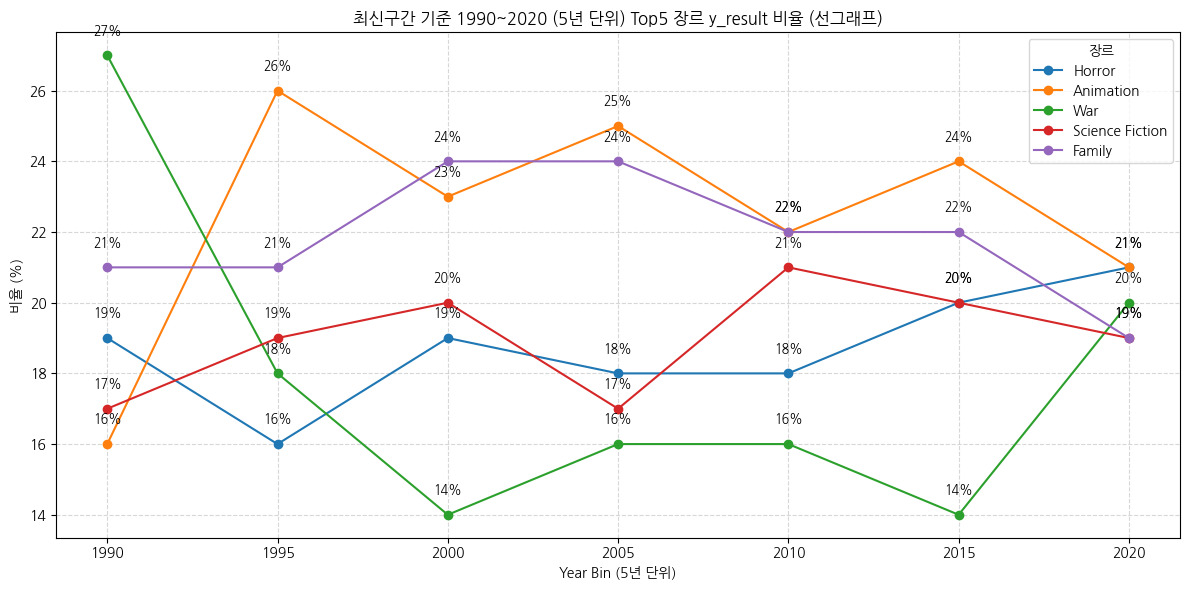

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 예시 데이터 (실제 집계값으로 교체 가능)
data = {
    "Year Bin": [1990, 1995, 2000, 2005, 2010, 2015, 2020],
    "Horror": [19, 16, 19, 18, 18, 20, 21],
    "Animation": [16, 26, 23, 25, 22, 24, 21],
    "War": [27, 18, 14, 16, 16, 14, 20],
    "Science Fiction": [17, 19, 20, 17, 21, 20, 19],
    "Family": [21, 21, 24, 24, 22, 22, 19]
}
df_plot = pd.DataFrame(data)

# 선그래프
plt.figure(figsize=(12,6))
for genre in df_plot.columns[1:]:
    plt.plot(df_plot["Year Bin"], df_plot[genre], marker="o", label=genre)
    # 라벨 (데이터 포인트 위에 값 표시)
    for x, y in zip(df_plot["Year Bin"], df_plot[genre]):
        plt.text(x, y+0.5, f"{y}%", ha="center", va="bottom", fontsize=9)

plt.title("최신구간 기준 1990~2020 (5년 단위) Top5 장르 y_result 비율 (선그래프)")
plt.xlabel("Year Bin (5년 단위)")
plt.ylabel("비율 (%)")
plt.legend(title="장르")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1695205250.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_trend_all[c] = df.loc[df[c] == 1].groupby("period")["y_result"].mean()



전체 장르의 5년 단위 평균 y_result 흐름:
             Action  Adventure  Animation    Comedy     Crime  Documentary  \
period                                                                       
1990–1994  1.208092   1.297030   1.047619  1.093117  1.070423     2.000000   
1995–1999  1.114286   1.422764   1.500000  1.117284  1.142857     0.600000   
2000–2004  1.071161   1.396341   1.553191  1.174242  1.000000     1.555556   
2005–2009  1.152597   1.256410   1.469880  1.118126  0.989848     1.153846   
2010–2014  1.336158   1.471366   1.475248  1.375536  1.103261     1.142857   
2015–2019  1.370262   1.432653   1.516129  1.334286  1.059603     0.714286   
2020–2024  1.153226   1.225806   1.371429  1.000000  0.918367     0.666667   

              Drama    Family   Fantasy   History    Horror     Music  \
period                                                                  
1990–1994  1.132404  1.301205  1.219178  0.703704  1.121212  1.000000   
1995–1999  0.978495  1.180723  1.128571  0.88000

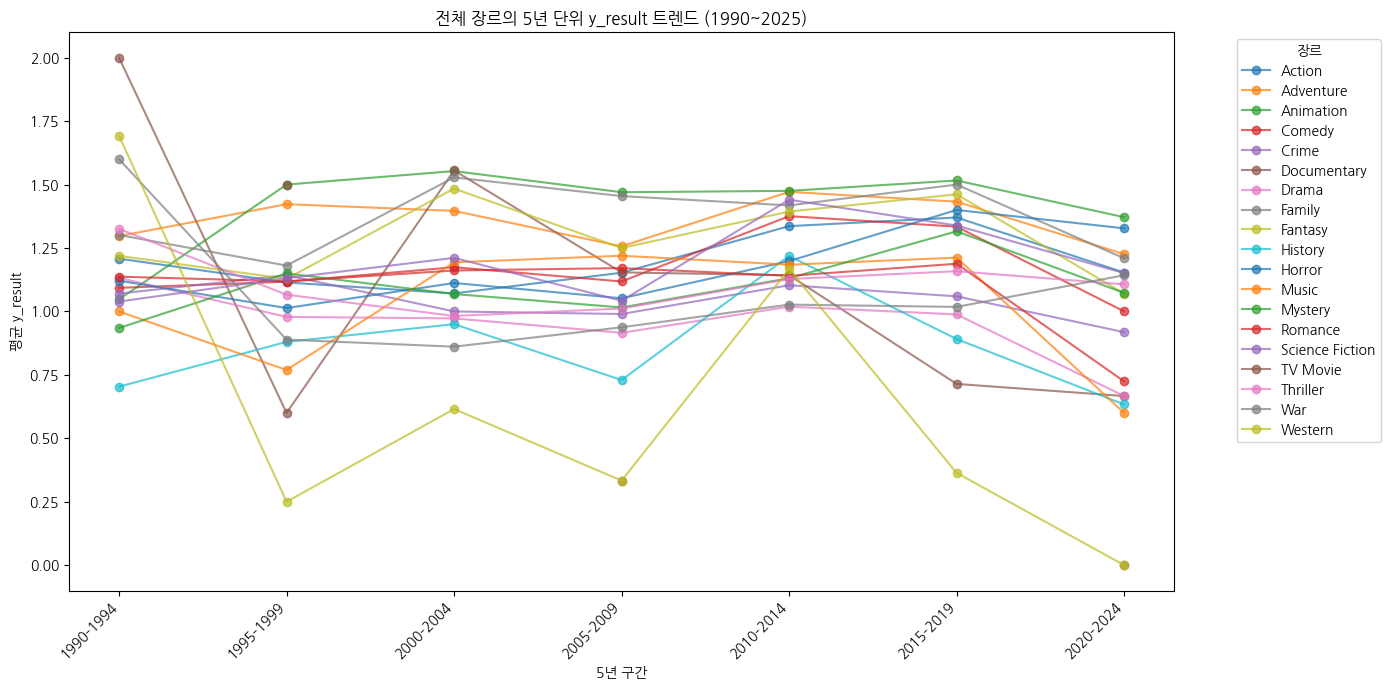

In [9]:
# ===== 0) 연도 & 5년 단위 구간(period) 만들기 =====
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["year"] = df["release_date"].dt.year
df = df[(df["year"] >= 1990) & (df["year"] <= 2025)].copy()

bins   = list(range(1990, 2030, 5))            # [1990,1995,...,2025]
labels = [f"{y}–{y+4}" for y in bins[:-1]]     # '1990–1994' 형식
df["period"] = pd.cut(df["year"], bins=bins, labels=labels,
                      right=True, include_lowest=True)

# ===== 1) 전체 장르별 5년 단위 평균 y_result 계산 =====
period_trend_all = {}
for c in cols:  # cols = ['Action','Adventure',...,'Western']
    period_trend_all[c] = df.loc[df[c] == 1].groupby("period")["y_result"].mean()

period_trend_all = pd.DataFrame(period_trend_all).reindex(labels)  # 구간 순서 맞춤

print("\n전체 장르의 5년 단위 평균 y_result 흐름:")
print(period_trend_all)

# ===== 2) 시각화 =====
plt.figure(figsize=(14,7))
for c in period_trend_all.columns:
    plt.plot(period_trend_all.index, period_trend_all[c], marker="o", label=c, alpha=0.7)

plt.title("전체 장르의 5년 단위 y_result 트렌드 (1990~2025)")
plt.xlabel("5년 구간")
plt.ylabel("평균 y_result")
plt.xticks(rotation=45, ha="right")
plt.legend(title="장르", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



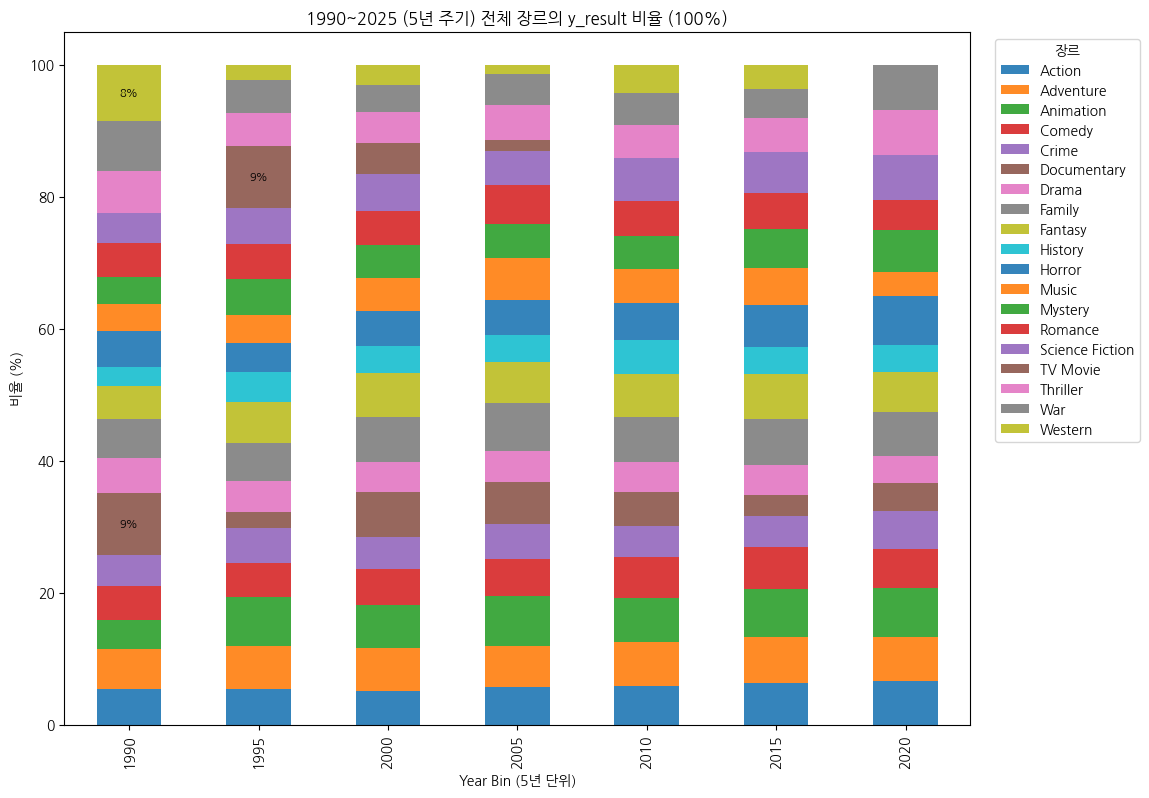

In [10]:
# 0) 준비: 연도/5년 주기
df["release_year"] = pd.to_datetime(df["release_date"], errors="coerce").dt.year
df["year_bin"] = (df["release_year"] // 5) * 5
df = df[df["year_bin"] >= 1990].copy()
df.loc[df["release_year"] >= 2025, "year_bin"] = 2025  # 2025 포함

# 1) 전체 장르별 5년 주기 평균 y_result 계산
trend_all = {}
for c in cols:   # cols = ['Action','Adventure',...,'Western'] 장르 리스트
    trend_all[c] = df.loc[df[c]==1].groupby("year_bin")["y_result"].mean()

trend_all = pd.DataFrame(trend_all).sort_index()

# 2) 100% 정규화
trend_all_pct = trend_all.div(trend_all.sum(axis=1), axis=0) * 100

# 3) 초기↔최신 변화(퍼센트p) 계산
first_bin = trend_all_pct.index.min()
latest_bin = trend_all_pct.index.max()
change_pp_all = (trend_all_pct.loc[latest_bin] - trend_all_pct.loc[first_bin]).sort_values()

# 4) 시각화: 왼쪽 = 100% 누적 막대(전체 장르), 오른쪽 = 변화(퍼센트p)
fig = plt.figure(figsize=(18,9))
gs = fig.add_gridspec(1, 2, width_ratios=[2.5, 1])

# (a) 100% 누적 막대
ax1 = fig.add_subplot(gs[0,0])
trend_all_pct.plot(kind="bar", stacked=True, ax=ax1, alpha=0.9)
ax1.set_title("1990~2025 (5년 주기) 전체 장르의 y_result 비율 (100%)")
ax1.set_xlabel("Year Bin (5년 단위)")
ax1.set_ylabel("비율 (%)")
ax1.legend(title="장르", bbox_to_anchor=(1.02, 1), loc="upper left")

# 막대 라벨(퍼센트 표시, 작은 값 생략)
for container in ax1.containers:
    labels = []
    for h in container:
        val = h.get_height()
        labels.append(f"{val:.0f}%" if val >= 8 else "")
    ax1.bar_label(container, labels=labels, label_type='center', fontsize=8)




In [11]:


# 2) 연도 추출
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["year"] = df["release_date"].dt.year
df = df[df["year"] >= 1980].copy()

# 3) 5년 단위 구간 생성
bins = list(range(1980, 2025, 5))   # [1980, 1985, ..., 2020]
labels = [f"{y}–{y+4}" for y in bins[:-1]]
df["five_year_bin"] = pd.cut(df["year"], bins=bins, labels=labels, right=True, include_lowest=True)

# 4) 장르 컬럼 정의 (0/1 더미)
genre_cols = [
    'Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family',
    'Fantasy','History','Horror','Music','Mystery','Romance','Science Fiction',
    'TV Movie','Thriller','War','Western'
]
genre_cols = [c for c in genre_cols if c in df.columns]

# 5) 시대 × 장르별 영화 편수
genre_by_period = df.groupby("five_year_bin")[genre_cols].sum()

print("=== 시대 × 장르별 영화 편수 ===")
print(genre_by_period)




=== 시대 × 장르별 영화 편수 ===
               Action  Adventure  Animation  Comedy  Crime  Documentary  \
five_year_bin                                                             
1980–1984           0          0          0       0      0            0   
1985–1989          23         16          1      31     23            0   
1990–1994         150         85         20     216    119            2   
1995–1999         175        123         38     324    133            5   
2000–2004         267        164         47     396    183           18   
2005–2009         308        234         83     491    197           26   
2010–2014         354        227        101     466    184           14   
2015–2019         343        245         93     350    151            7   

               Drama  Family  Fantasy  History  Horror  Music  Mystery  \
five_year_bin                                                            
1980–1984          0       0        0        0       0      0        0   
1985

/tmp/ipython-input-1401045491.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genre_by_period = df.groupby("five_year_bin")[genre_cols].sum()


/tmp/ipython-input-1142495613.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_tbl = df.groupby("five_year_bin")[genre_cols].sum().reindex(labels).fillna(0).astype(int)


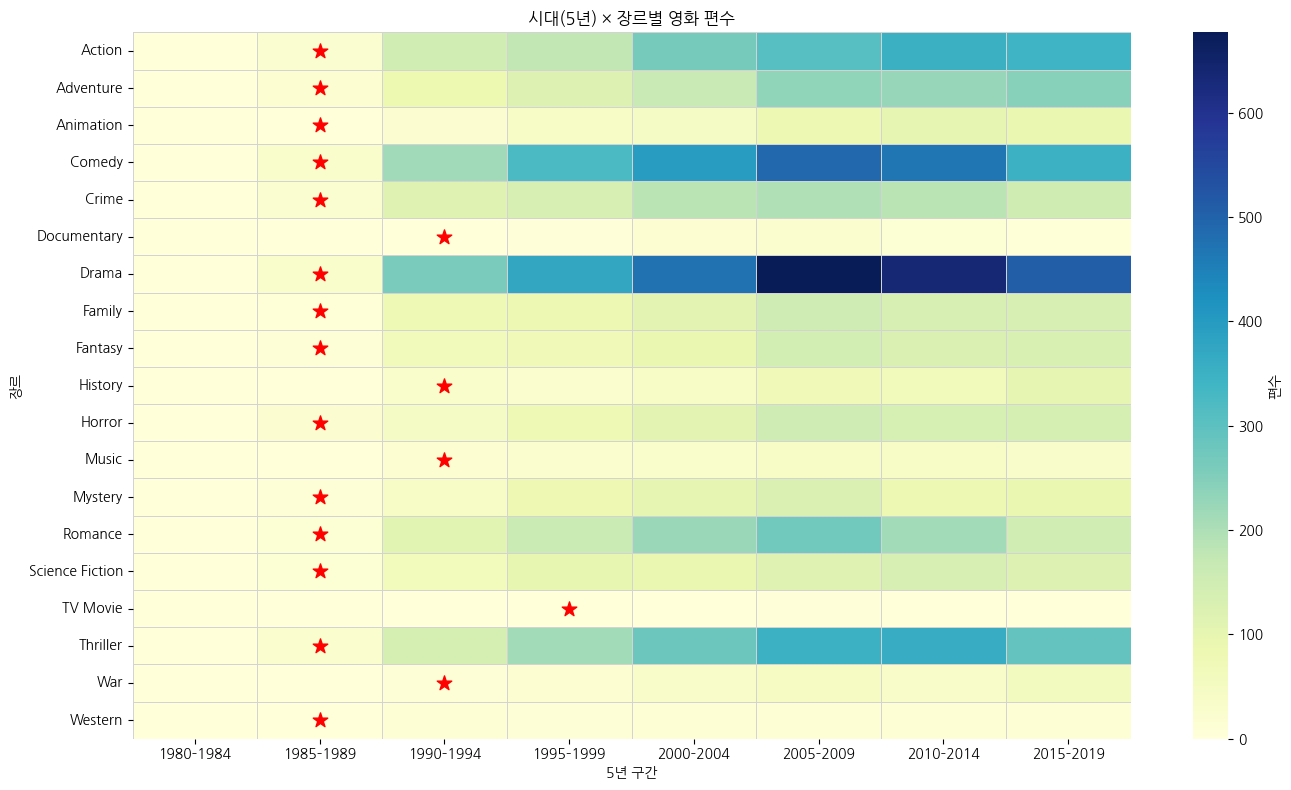

=== 장르별 최초 등장 구간 ===
Action         : 1985–1989
Adventure      : 1985–1989
Animation      : 1985–1989
Comedy         : 1985–1989
Crime          : 1985–1989
Documentary    : 1990–1994
Drama          : 1985–1989
Family         : 1985–1989
Fantasy        : 1985–1989
History        : 1990–1994
Horror         : 1985–1989
Music          : 1990–1994
Mystery        : 1985–1989
Romance        : 1985–1989
Science Fiction: 1985–1989
TV Movie       : 1995–1999
Thriller       : 1985–1989
War            : 1990–1994
Western        : 1985–1989


In [12]:

# ===== 2) 연도 & 5년 구간
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["year"] = df["release_date"].dt.year
df = df[df["year"] >= 1980].copy()

bins   = list(range(1980, 2025, 5))
labels = [f"{y}–{y+4}" for y in bins[:-1]]
df["five_year_bin"] = pd.cut(df["year"], bins=bins, labels=labels, right=True, include_lowest=True)

# ===== 3) 장르 더미 컬럼 자동 선택
genre_cols = df.loc[:, "Action":"Western"].columns.tolist()

# ===== 4) 시대 × 장르별 편수
count_tbl = df.groupby("five_year_bin")[genre_cols].sum().reindex(labels).fillna(0).astype(int)

# ===== 5) 각 장르 최초 등장 구간
first_seen = {}
for g in genre_cols:
    nz = np.where(count_tbl[g].values > 0)[0]
    first_seen[g] = labels[nz[0]] if len(nz) else None

# ===== 6) 히트맵 시각화
plt.figure(figsize=(14,8))
sns.heatmap(count_tbl.T, cmap="YlGnBu", linewidths=.5, linecolor="lightgray", cbar_kws={"label":"편수"})
plt.title("시대(5년) × 장르별 영화 편수")
plt.xlabel("5년 구간")
plt.ylabel("장르")

# ===== 7) 첫 등장 시점에 별표 표시
for gi, g in enumerate(count_tbl.columns):  # five_year_bin 순회
    pass  # (이건 X, 잘못됨)

for gi, g in enumerate(count_tbl.columns):  # 여기서 g는 구간, 잘못
    pass

# 고침: index=구간, columns=장르 → 전치해서 M 사용
M = count_tbl.T
for gi, g in enumerate(M.index):
    nz = np.where(M.loc[g].values > 0)[0]
    if len(nz) > 0:
        fi = nz[0]
        plt.scatter(fi+0.5, gi+0.5, marker="*", s=120, color="red")  # 첫 등장 별표

plt.tight_layout()
plt.show()

# ===== 8) 장르별 최초 등장 구간 출력
print("=== 장르별 최초 등장 구간 ===")
for g, f in first_seen.items():
    print(f"{g:15s}: {f}")


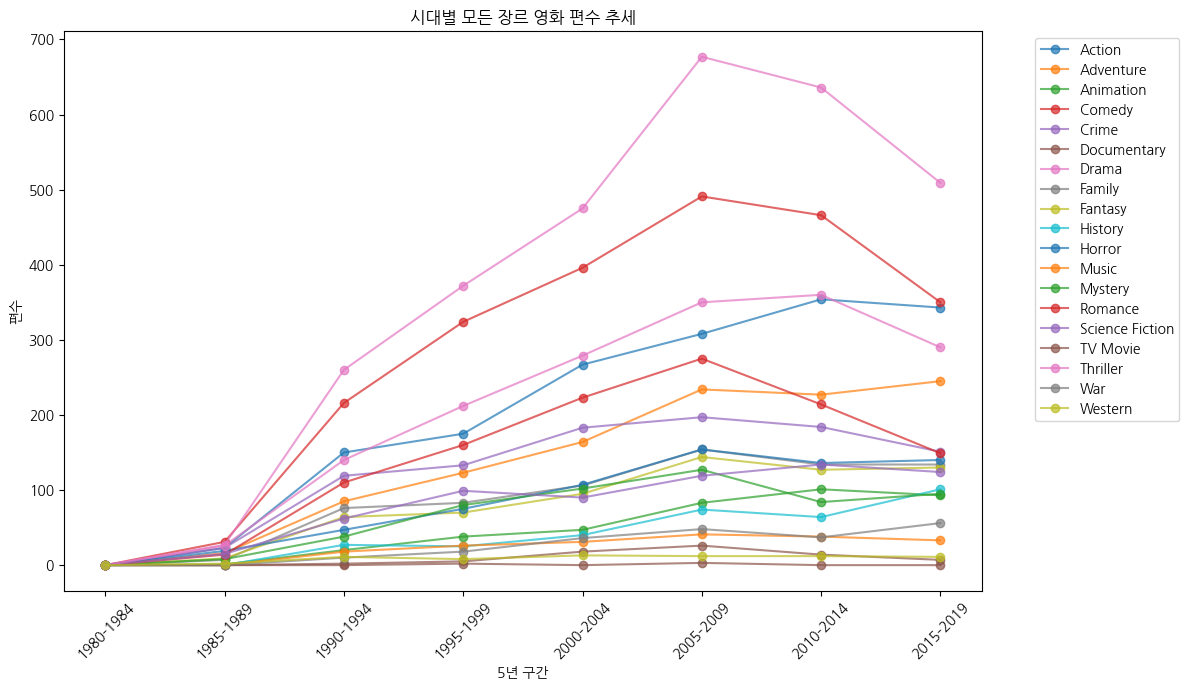

In [13]:
plt.figure(figsize=(12,7))
for col in count_tbl.columns:   # 모든 장르
    plt.plot(count_tbl.index, count_tbl[col], marker="o", label=col, alpha=0.7)

plt.title("시대별 모든 장르 영화 편수 추세")
plt.xlabel("5년 구간")
plt.ylabel("편수")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")  # 범례를 밖으로
plt.tight_layout()
plt.show()


파묘시작~

애니메이션-안정성의 원천이 공급 파이프라인(연 1~2편 대형 프랜차이즈) 때문인지,
아니면 소수 스튜디오(디즈니/픽사/드림웍스 등) 스튜디오 효과인지.

Family 동시 태깅의 비중: 실은 “애니=패밀리”가 많아 Family 하락을 일부 상쇄했을 가능성.

예산·표본 규모가 꾸준했는지(대형작 몇 편에 성과가 집중되는지).

In [18]:
# 애니 편수/성과 점유율
ani_cnt  = df.groupby("period")["Animation"].sum()
ani_perf = df.loc[df["Animation"]==1].groupby("period")["y_result"].sum()

# Calculate the total count of movies per period
tot = df.groupby("period").size()

share_ani_cnt  = (ani_cnt / tot * 100).reindex(labels)
share_ani_perf = (ani_perf / df.groupby("period")["y_result"].sum() * 100).reindex(labels)

print("Animation 편수 점유율(%):\n", share_ani_cnt.round(1))
print("Animation 성과 점유율(%):\n", share_ani_perf.round(1))

Animation 편수 점유율(%):
 period
1980–1984    NaN
1985–1989    NaN
1990–1994    3.3
1995–1999    4.9
2000–2004    4.6
2005–2009    6.2
2010–2014    7.4
2015–2019    8.4
dtype: float64
Animation 성과 점유율(%):
 period
1980–1984     NaN
1985–1989     NaN
1990–1994     3.0
1995–1999     7.0
2000–2004     6.4
2005–2009     8.6
2010–2014     9.2
2015–2019    10.7
Name: y_result, dtype: float64


/tmp/ipython-input-3919518686.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ani_cnt  = df.groupby("period")["Animation"].sum()
/tmp/ipython-input-3919518686.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ani_perf = df.loc[df["Animation"]==1].groupby("period")["y_result"].sum()
/tmp/ipython-input-3919518686.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tot = df.groupby("period").size()
/tmp/ipython-input-

In [19]:


def summarize_animation(df, start=1990, end=2025, step=5):
    df = df.copy()
    # 날짜 → 연도 → 5년 구간(period)
    df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
    df["year"] = df["release_date"].dt.year
    df = df[(df["year"] >= start) & (df["year"] <= end)].copy()

    bins   = list(range(start, end + step, step))
    labels = [f"{y}–{y+step-1}" for y in bins[:-1]]
    df["period"] = pd.cut(df["year"], bins=bins, labels=labels,
                          include_lowest=True, right=True)

    # 전체 분모 (편수/성과 합)
    totals_cnt  = df.groupby("period", observed=False).size().reindex(labels).astype(float)
    totals_perf = df.groupby("period", observed=False)["y_result"].sum().reindex(labels).astype(float)

    # 애니 편수/성과/평균
    ani_cnt  = df.groupby("period", observed=False)["Animation"].sum().reindex(labels).fillna(0.0)
    ani_perf = df.loc[df["Animation"]==1].groupby("period", observed=False)["y_result"] \
                 .sum().reindex(labels).fillna(0.0)
    ani_mean = df.loc[df["Animation"]==1].groupby("period", observed=False)["y_result"] \
                 .mean().reindex(labels)

    # 점유율(%) — 분모=0 또는 편수=0이면 0으로 표기
    share_cnt  = ((ani_cnt  / totals_cnt.replace(0, np.nan))  * 100).fillna(0.0)
    share_perf = ((ani_perf / totals_perf.replace(0, np.nan)) * 100).fillna(0.0)

    excess_pp = (share_perf - share_cnt).fillna(0.0)

    summary = pd.DataFrame({
        "count": ani_cnt,
        "count_share_%": share_cnt,
        "perf_sum": ani_perf,
        "perf_share_%": share_perf,
        "mean_y_result": ani_mean,      # 표본 없으면 NaN 유지
        "excess_perf_pp": excess_pp
    }).reindex(labels).round(2)

    return summary, labels

# ---- 실행 ----
anim_summary, labels = summarize_animation(df, start=1990, end=2025, step=5)
print(anim_summary)







           count  count_share_%  perf_sum  perf_share_%  mean_y_result  \
period                                                                   
1990–1994     21           3.26        22          3.02           1.05   
1995–1999     38           4.93        57          6.96           1.50   
2000–2004     47           4.64        73          6.43           1.55   
2005–2009     83           6.18       122          8.56           1.47   
2010–2014    101           7.45       149          9.17           1.48   
2015–2019     93           8.39       141         10.71           1.52   
2020–2024     35          10.09        48         13.91           1.37   

           excess_perf_pp  
period                     
1990–1994           -0.24  
1995–1999            2.03  
2000–2004            1.79  
2005–2009            2.38  
2010–2014            1.72  
2015–2019            2.32  
2020–2024            3.83  


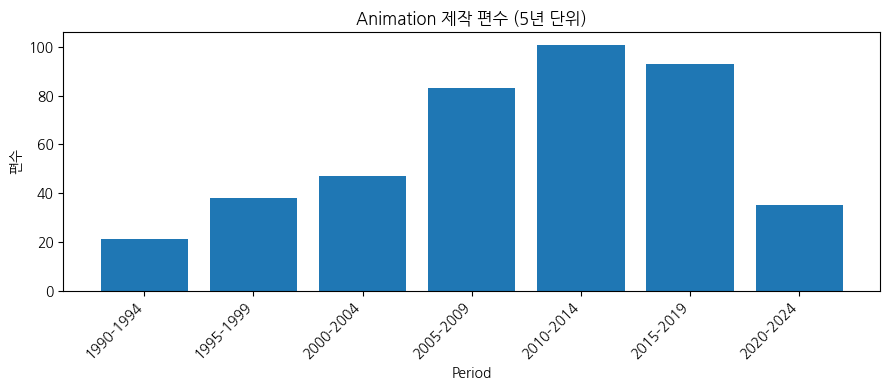

In [20]:
# (1) 애니 제작 편수
plt.figure(figsize=(9,4))
plt.bar(anim_summary.index.astype(str), anim_summary["count"])
plt.title("Animation 제작 편수 (5년 단위)")
plt.xlabel("Period"); plt.ylabel("편수")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()



In [ ]:

# (2) 점유율(편수% vs 성과%) 오버레이
plt.figure(figsize=(9,4))
plt.plot(anim_summary.index.astype(str), anim_summary["count_share_%"], marker="o", label="편수 점유율(%)")
plt.plot(anim_summary.index.astype(str), anim_summary["perf_share_%"],  marker="o", label="성과 점유율(%)")
plt.title("Animation 점유율(%) — 편수 vs 성과")
plt.xlabel("Period"); plt.ylabel("%")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()



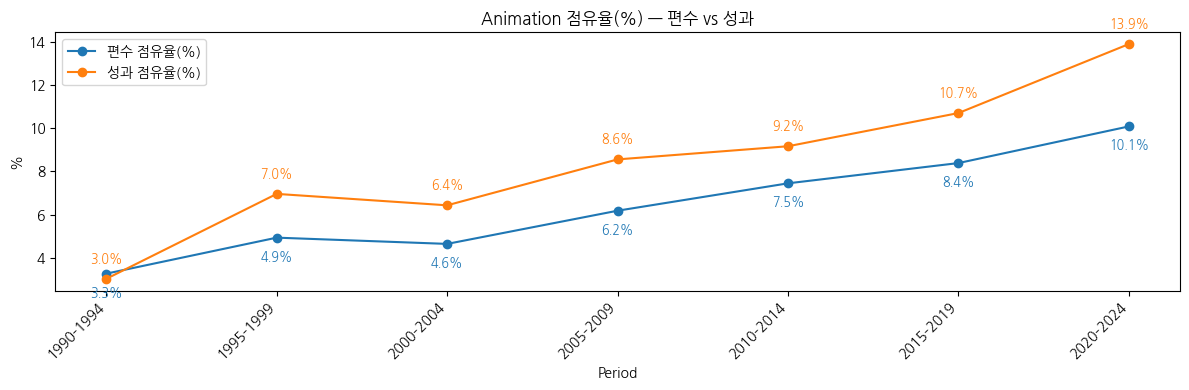

In [21]:
plt.figure(figsize=(12,4))

# 1) 편수 점유율
plt.plot(anim_summary.index.astype(str), anim_summary["count_share_%"],
         marker="o", label="편수 점유율(%)", color="C0")
for x, y in zip(anim_summary.index.astype(str), anim_summary["count_share_%"]):
    plt.text(x, y-0.6, f"{y:.1f}%", ha="center", va="top", fontsize=9, color="C0")

# 2) 성과 점유율
plt.plot(anim_summary.index.astype(str), anim_summary["perf_share_%"],
         marker="o", label="성과 점유율(%)", color="C1")
for x, y in zip(anim_summary.index.astype(str), anim_summary["perf_share_%"]):
    plt.text(x, y+0.6, f"{y:.1f}%", ha="center", va="bottom", fontsize=9, color="C1")

plt.title("Animation 점유율(%) — 편수 vs 성과")
plt.xlabel("Period")
plt.ylabel("%")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


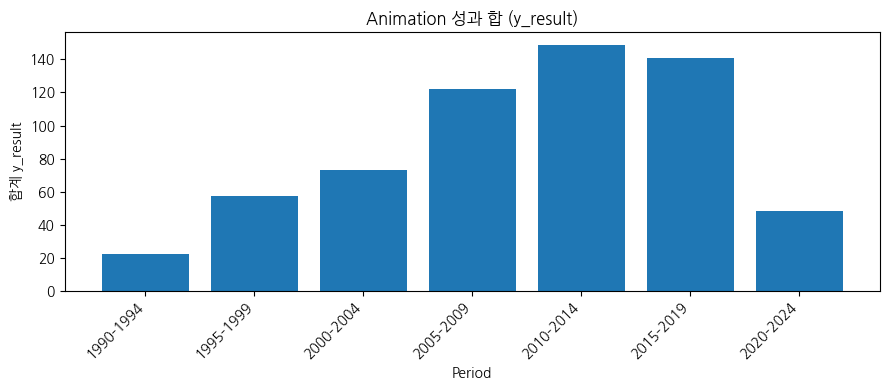

In [22]:


# (3) 성과 합(y_result)
plt.figure(figsize=(9,4))
plt.bar(anim_summary.index.astype(str), anim_summary["perf_sum"])
plt.title("Animation 성과 합 (y_result)")
plt.xlabel("Period"); plt.ylabel("합계 y_result")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()




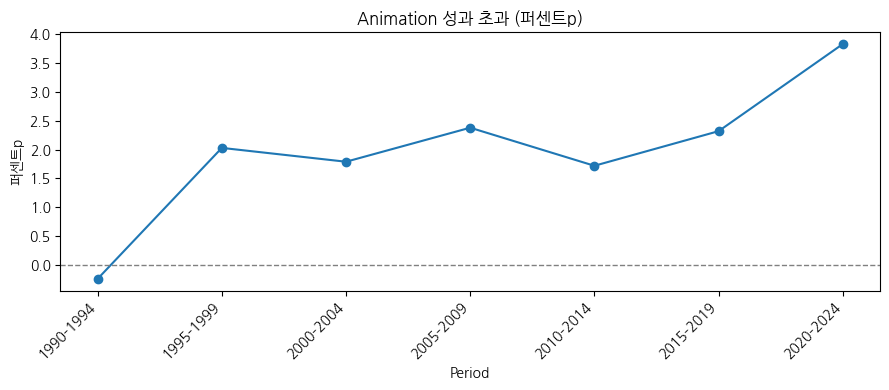

In [23]:


# (4) 성과 초과(퍼센트p) = 성과% − 편수%
plt.figure(figsize=(9,4))
plt.plot(anim_summary.index.astype(str), anim_summary["excess_perf_pp"], marker="o")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Animation 성과 초과 (퍼센트p)")
plt.xlabel("Period"); plt.ylabel("퍼센트p")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()


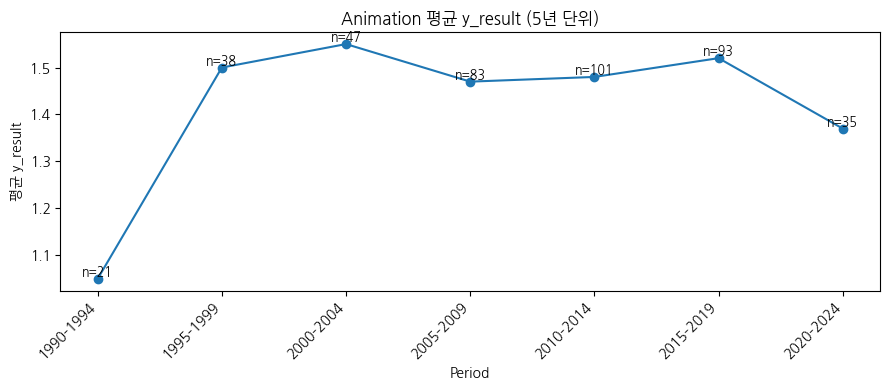

In [24]:
xs = np.arange(len(anim_summary))
y  = anim_summary["mean_y_result"].values
n  = anim_summary["count"].values  # 표본수

plt.figure(figsize=(9,4))
plt.plot(xs, y, marker="o")
# 각 점 위에 표본수 표시 (NaN은 건너뜀)
for xi, yi, ni in zip(xs, y, n):
    if not np.isnan(yi):
        plt.text(xi, yi, f"n={int(ni)}", ha="center", va="bottom", fontsize=9)

plt.title("Animation 평균 y_result (5년 단위)")
plt.xlabel("Period"); plt.ylabel("평균 y_result")
plt.xticks(xs, anim_summary.index.astype(str), rotation=45, ha="right")
plt.tight_layout(); plt.show()

In [ ]:
# (선택) CSV 저장
# anim_summary.to_csv("animation_5y_summary.csv", encoding="utf-8-sig")
